# Three Layer NN With Dropout

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from torchinfo import summary

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from tqdm import tqdm

In [3]:
DATA_PATH = "../data/filtered_df.csv"
SAVED_MODELS_PATH = "saved_models/"
RUNS_PATH = "runs/"

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
class TemperatureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TemperatureDataset, self).__init__()

        self.X = torch.from_numpy(X).type(torch.FloatTensor).to(DEVICE)
        self.y = torch.from_numpy(y).type(torch.LongTensor).to(DEVICE)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
df = pd.read_csv(DATA_PATH, index_col=False)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1432,1433,1434,1435,1436,1437,1438,1439,disease,disease_encoded
0,0.324229,0.321773,0.293289,0.251415,0.233319,0.215165,0.199983,0.199940,0.199452,0.222875,...,0.328832,0.336572,0.346011,0.366030,0.367564,0.353988,0.391509,0.396744,non-tubercular bacterial infection,2
1,0.711537,0.716489,0.692864,0.663745,0.656331,0.649800,0.647031,0.654493,0.666713,0.704651,...,0.461699,0.463528,0.465851,0.479131,0.473387,0.448613,0.474214,0.469184,non-infectious diseases,1
2,-0.998812,-0.965014,-0.949616,-0.972169,-0.964058,-0.958246,-0.951069,-0.916209,-0.894729,-0.853034,...,-0.674240,-0.673875,-0.668928,-0.664293,-0.682767,-0.685365,-0.633705,-0.643017,non-infectious diseases,1
3,0.397786,0.394290,0.364575,0.323128,0.305324,0.287857,0.273731,0.274179,0.275278,0.300820,...,0.094263,0.104663,0.117509,0.138585,0.140308,0.133645,0.178601,0.185257,non-infectious diseases,1
4,-0.588411,-0.847557,-0.706788,-1.122207,-0.945154,-0.596463,-0.514640,-0.474065,-0.440717,-0.424736,...,-0.441703,-0.373206,-0.404157,-0.374855,-0.484079,-0.570954,-0.589012,-0.597433,dengue,0


In [7]:
X = df.drop("disease", axis=1)
X = X.drop("disease_encoded", axis=1)
y = df["disease_encoded"]

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [9]:
train_dataset = TemperatureDataset(train_data, train_labels)
test_dataset = TemperatureDataset(test_data, test_labels)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [11]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.dense1 = nn.Linear(1440, 1024)
    self.dense2 = nn.Linear(1024, 512)
    self.dense3 = nn.Linear(512, 64)
    self.dense4 = nn.Linear(64, 4)

    self.dropout = nn.Dropout(0.3)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = x.to(DEVICE)

    x = self.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.relu(self.dense2(x))
    x = self.dropout(x)
    x = self.relu(self.dense3(x))
    x = self.dropout(x)

    return self.softmax(self.dense4(x))

In [12]:
sample_x, sample_y = next(iter(train_loader))

## SGD

In [13]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (dense1): Linear(in_features=1440, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=512, bias=True)
  (dense3): Linear(in_features=512, out_features=64, bias=True)
  (dense4): Linear(in_features=64, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [14]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Linear: 1-1                            [8, 1024]                 1,475,584
├─ReLU: 1-2                              [8, 1024]                 --
├─Dropout: 1-3                           [8, 1024]                 --
├─Linear: 1-4                            [8, 512]                  524,800
├─ReLU: 1-5                              [8, 512]                  --
├─Dropout: 1-6                           [8, 512]                  --
├─Linear: 1-7                            [8, 64]                   32,832
├─ReLU: 1-8                              [8, 64]                   --
├─Dropout: 1-9                           [8, 64]                   --
├─Linear: 1-10                           [8, 4]                    260
├─Softmax: 1-11                          [8, 4]                    --
Total params: 2,033,476
Trainable params: 2,033,476
Non-trainable pa

In [15]:
tb_board = RUNS_PATH + "three_layer_nn_with_dropout_sgd"
writer = SummaryWriter(tb_board)

In [17]:
writer.add_graph(model, sample_x)

In [18]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [20]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3859957615534464 - Accuracy: 0.30434782608695654 - Precision: 0.15013802622498273 - Recall: 0.30434782608695654 - F1: 0.16713489409141583
Epoch: 2 - Loss: 1.3855800867080688 - Accuracy: 0.33043478260869563 - Precision: 0.3502776649058648 - Recall: 0.33043478260869563 - F1: 0.1960298411044869
Epoch: 3 - Loss: 1.384866182009379 - Accuracy: 0.30434782608695654 - Precision: 0.279715562779358 - Recall: 0.30434782608695654 - F1: 0.18184533934687025
Epoch: 4 - Loss: 1.3839575052261353 - Accuracy: 0.30434782608695654 - Precision: 0.13407114624505928 - Recall: 0.30434782608695654 - F1: 0.1570143499678732
Epoch: 5 - Loss: 1.3860259771347045 - Accuracy: 0.2956521739130435 - Precision: 0.09157368218545595 - Recall: 0.2956521739130435 - F1: 0.1398354876615746
Epoch: 6 - Loss: 1.3828980843226115 - Accuracy: 0.2956521739130435 - Precision: 0.0949341842840048 - Recall: 0.2956521739130435 - F1: 0.14371980676328502
Epoch: 7 - Loss: 1.382793919245402 - Accuracy: 0.3217391304347826 - Pr

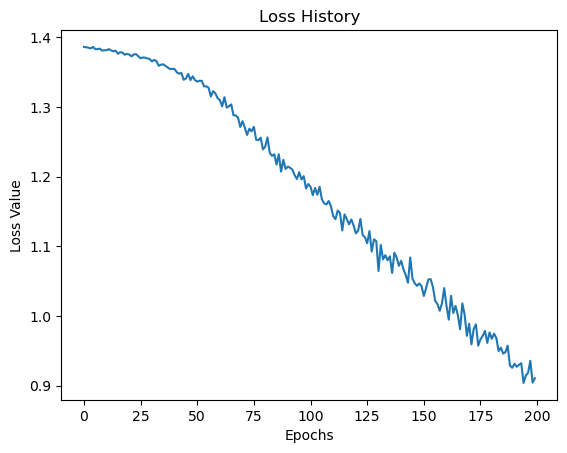

In [21]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_three_layer_nn_with_dropout.pdf", bbox_inches="tight")
plt.show()

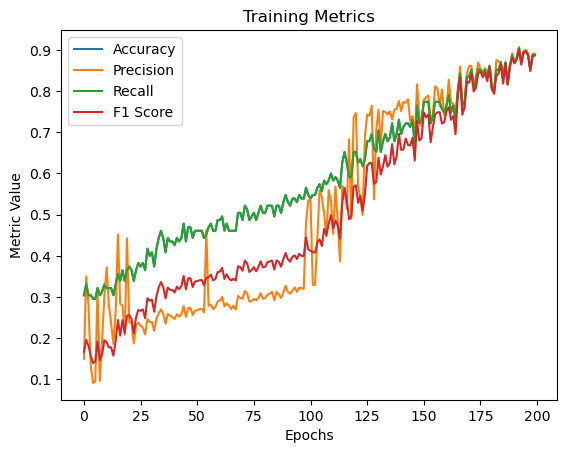

In [22]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_three_layer_nn_with_dropout.pdf", bbox_inches="tight")
plt.show()

In [23]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.5875652173913043
Mean Training Precision: 0.5050934665130296
Mean Training Recall: 0.5875652173913043
Mean Training F1 Score: 0.5005340553395259


In [24]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [25]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted')
  recall = recall_score(yhat, y, average='weighted')
  f1 = f1_score(yhat, y, average='weighted')

In [26]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.288446307182312
Testing Accuracy: 0.41379310344827586
Testing Precision: 0.5517241379310345
Testing Recall: 0.41379310344827586
Testing F1 Score: 0.4597701149425287


## Adam

In [27]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (dense1): Linear(in_features=1440, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=512, bias=True)
  (dense3): Linear(in_features=512, out_features=64, bias=True)
  (dense4): Linear(in_features=64, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [28]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Linear: 1-1                            [8, 1024]                 1,475,584
├─ReLU: 1-2                              [8, 1024]                 --
├─Dropout: 1-3                           [8, 1024]                 --
├─Linear: 1-4                            [8, 512]                  524,800
├─ReLU: 1-5                              [8, 512]                  --
├─Dropout: 1-6                           [8, 512]                  --
├─Linear: 1-7                            [8, 64]                   32,832
├─ReLU: 1-8                              [8, 64]                   --
├─Dropout: 1-9                           [8, 64]                   --
├─Linear: 1-10                           [8, 4]                    260
├─Softmax: 1-11                          [8, 4]                    --
Total params: 2,033,476
Trainable params: 2,033,476
Non-trainable pa

In [29]:
tb_board = RUNS_PATH + "three_layer_nn_with_dropout_adam"
writer = SummaryWriter(tb_board)

In [30]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.4053881645202637 - Accuracy: 0.22608695652173913 - Precision: 0.17501725327812281 - Recall: 0.22608695652173913 - F1: 0.1885501092645146
Epoch: 2 - Loss: 1.3826611518859864 - Accuracy: 0.34782608695652173 - Precision: 0.20230100334448162 - Recall: 0.34782608695652173 - F1: 0.2553764581124072
Epoch: 3 - Loss: 1.3373286962509154 - Accuracy: 0.4 - Precision: 0.3002635046113307 - Recall: 0.4 - F1: 0.29820045766590386
Epoch: 4 - Loss: 1.3357013463974 - Accuracy: 0.3826086956521739 - Precision: 0.2890420557578972 - Recall: 0.3826086956521739 - F1: 0.31455072463768113
Epoch: 5 - Loss: 1.3651091655095418 - Accuracy: 0.3565217391304348 - Precision: 0.2589558321055766 - Recall: 0.3565217391304348 - F1: 0.2682062143531409
Epoch: 6 - Loss: 1.3648948987325034 - Accuracy: 0.3739130434782609 - Precision: 0.258773541324223 - Recall: 0.3739130434782609 - F1: 0.28611712403080264
Epoch: 7 - Loss: 1.371450956662496 - Accuracy: 0.3826086956521739 - Precision: 0.4351276742581091 - Recall:

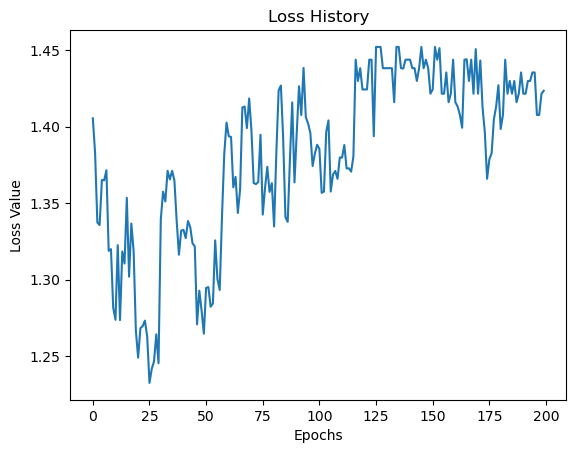

In [33]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_three_layer_nn_with_dropout_adam.pdf", bbox_inches="tight")
plt.show()

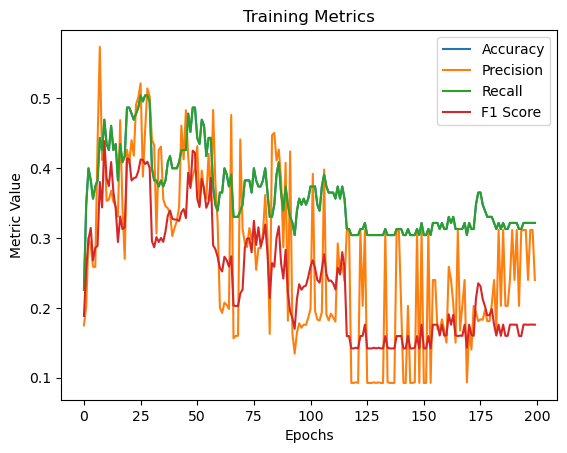

In [34]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_three_layer_nn_with_dropout_adam.pdf", bbox_inches="tight")
plt.show()

In [35]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.3617826086956522
Mean Training Precision: 0.26996936396666127
Mean Training Recall: 0.3617826086956522
Mean Training F1 Score: 0.2435433865504496


In [36]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [37]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [38]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.329875111579895
Testing Accuracy: 0.41379310344827586
Testing Precision: 1.0
Testing Recall: 0.41379310344827586
Testing F1 Score: 0.5853658536585364
